# Introduction

I was curious what the relationship between file size and mapped reads were.

In [1]:
import numpy
import pandas
import sys
import os
from functools import partial
from woldrnaseq.models import (
    load_all_samstats,
    load_experiments, 
    load_library_tables, 
    genome_name_from_library, 
    find_library_analysis_file
)
from generate_combined_transcript_C1 import ASOF_RUN17_library_files
from glob import glob
import rdflib
from requests import HTTPError
from xopen import xopen
import json
from matplotlib import pyplot

In [2]:
%matplotlib inline

In [3]:
vdir = 'all_analysis_vdir'

In [4]:
refined_library_files = [
 '/woldlab/castor/home/sau/flowcells/C1_mouse_limb_combined_Mar_2017/library_mm10_clean.tsv',
 '/woldlab/castor/home/sau/flowcells/HFNLNBCX2/library.tsv',
 '/woldlab/castor/home/sau/flowcells/H7CNTBCX2/library.tsv',
 '/woldlab/castor/home/sau/flowcells/HFNLTBCX2/library.tsv',
 '/woldlab/castor/home/sau/flowcells/HF7NTBCX2/library.tsv',
 '/woldlab/castor/home/sau/flowcells/HFNYNBCX2/library.tsv']

In [5]:
libraries = load_library_tables(refined_library_files)

In [6]:
libraries.index = [x.replace('_mm10', '').replace('_clean', '') for x in libraries.index]

In [7]:
samstats = load_all_samstats(libraries)

In [8]:
file_details = pandas.read_csv(os.path.join(vdir, 'file_details.csv'))
file_details.head()

,uuid,file_accession,library_id:skip,md5sum,flowcell_details:json,run_type,read_length:integer,file_size:integer,submitted_file_name
0,NaN,ENCFF178OXC,18251_A1,8489a39c1f9802a69f23e35750ff4a8e,"[{""machine"": ""http://jumpgate.caltech.edu/sequ...",single-ended,50,25919352,/woldlab/castor/home/sau/flowcells/C1_mouse_li...
1,NaN,ENCFF547WQZ,18251_A1,19355390ffad4017f4b3d80f27ca2763,"[{""machine"": ""http://jumpgate.caltech.edu/sequ...",single-ended,50,25718028,/woldlab/castor/home/sau/flowcells/C1_mouse_li...
2,NaN,NaN,18251_A2,b6a127c848716018d592bb9eb65da4ea,"[{""machine"": ""http://jumpgate.caltech.edu/sequ...",single-ended,50,26320606,/woldlab/castor/home/sau/flowcells/C1_mouse_li...
3,NaN,NaN,18251_A2,cec750266fc098378f7d69475a72d737,"[{""machine"": ""http://jumpgate.caltech.edu/sequ...",single-ended,50,26429050,/woldlab/castor/home/sau/flowcells/C1_mouse_li...
4,NaN,ENCFF752SWG,18251_A3,fbd71f67c646fa73b0b141ab93f83581,"[{""machine"": ""http://jumpgate.caltech.edu/sequ...",single-ended,50,23873809,/woldlab/castor/home/sau/flowcells/C1_mouse_li...


In [9]:
file_size = file_details[['library_id:skip', 'file_size:integer']].groupby(['library_id:skip']).sum()

In [10]:
file_size.loc['18251_A1'], file_details[file_details['library_id:skip'] == '18251_A1']['file_size:integer'].sum()

(file_size:integer    51637380
 Name: 18251_A1, dtype: int64, 51637380)

In [11]:
sizes = pandas.merge(
    file_size,
    samstats[['Total Aligned Reads', 'Fraction Mapped']],
    left_index=True,
    right_index=True,
)

In [12]:
sizes.head()

,file_size:integer,Total Aligned Reads,Fraction Mapped
17327_A1,155260145,2748646.0,0.592372
17327_A10,60361404,1109535.0,0.596038
17327_A11,174665516,3217854.0,0.624463
17327_A12,177954740,3311980.0,0.586764
17327_A2,128156340,2367205.0,0.601362


Compare file size to total number of aligned reads

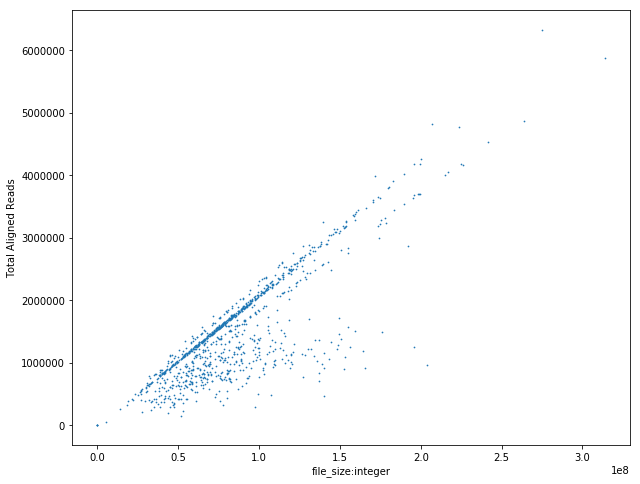

In [13]:
sizes.plot.scatter(x='file_size:integer', y='Total Aligned Reads', figsize=(10,8), s=.5)

Zoom in on libraries with relatively few total aligned reads

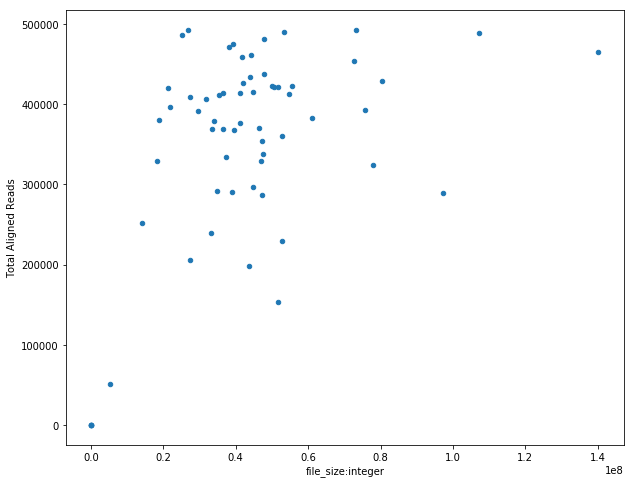

In [14]:
sizes[sizes['Total Aligned Reads']<500000].plot.scatter(x='file_size:integer', y='Total Aligned Reads', figsize=(10,8))

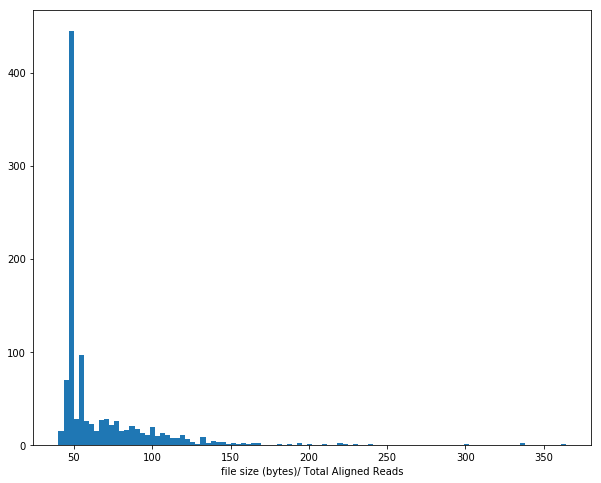

In [15]:
f = pyplot.figure(figsize=(10,8))
a = f.add_subplot(1,1,1)
a.set_xlabel('file size (bytes)/ Total Aligned Reads')
_ = a.hist(sizes['file_size:integer']/sizes['Total Aligned Reads'], bins=100)

Compute 

In [16]:
sizes['normalized_file_size'] = sizes['file_size:integer'] * sizes['Fraction Mapped']

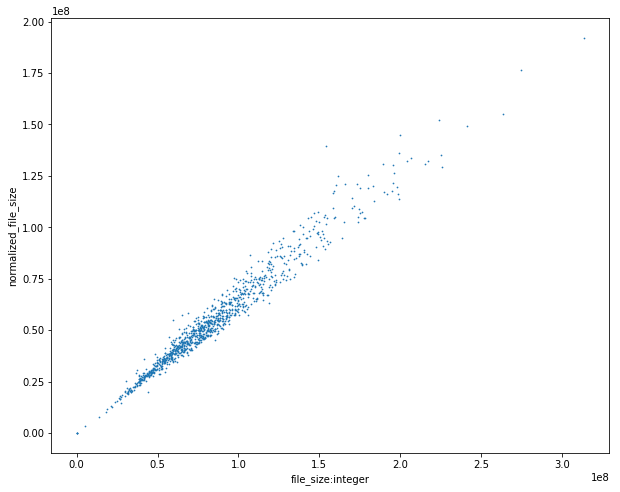

In [17]:
sizes.plot.scatter(x='file_size:integer', y='normalized_file_size', figsize=(10,8), s=.5)

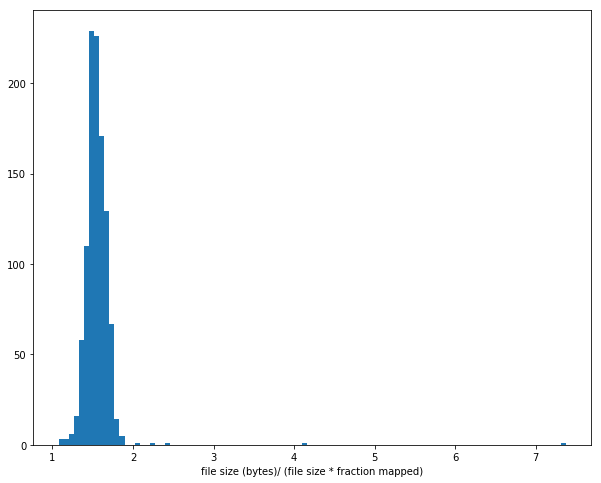

In [18]:
f = pyplot.figure(figsize=(10,8))
a = f.add_subplot(1,1,1)
a.set_xlabel('file size (bytes)/ (file size * fraction mapped)')
_ = a.hist(sizes['file_size:integer']/sizes['normalized_file_size'], bins=100)

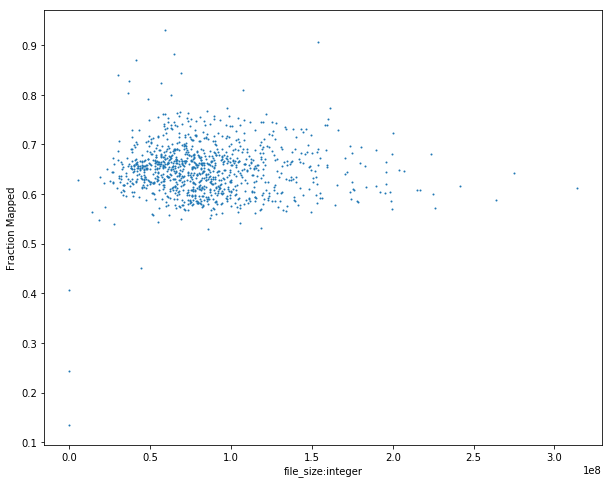

In [19]:
sizes.plot.scatter(x='file_size:integer', y='Fraction Mapped', figsize=(10,8), s=1)

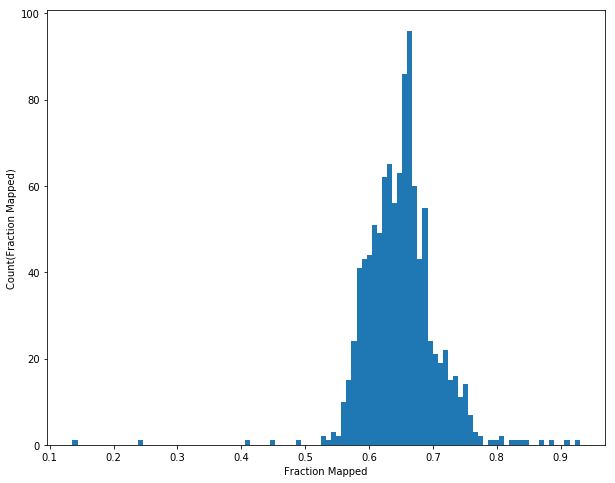

In [20]:
f = pyplot.figure(figsize=(10,8))
a = f.add_subplot(1,1,1)
a.set_xlabel('Fraction Mapped')
a.set_ylabel('Count(Fraction Mapped)')
_ = a.hist(sizes['Fraction Mapped'], bins=100)

In [21]:
sizes['Fraction Mapped'].median()

0.6504220956110001

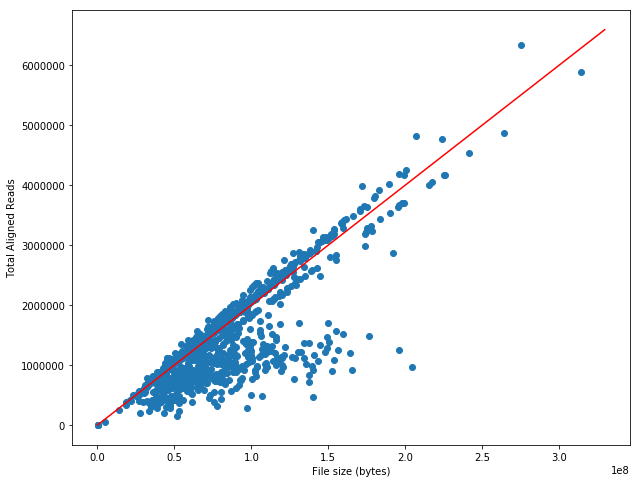

In [22]:
f = pyplot.figure(figsize=(10,8))
a = f.add_subplot(1,1,1)
a.set_xlabel('File size (bytes)')
a.set_ylabel('Total Aligned Reads')
a.scatter(x='file_size:integer', y='Total Aligned Reads', data=sizes)
x_start, x_end = a.get_xlim()
x_start = int(numpy.floor(x_start))
x_end = int(numpy.ceil(x_end))
m, b = numpy.polyfit(sizes['file_size:integer'], sizes['Total Aligned Reads'], deg=1)
m = numpy.round(m, 2)
_ = a.plot([0,x_end], [0,x_end*m], color='r')


In [23]:
numpy.polyfit(sizes['file_size:integer'], sizes['Total Aligned Reads'], deg=1)

array([ 1.77532802e-02, -3.13384122e+04])

In [24]:
numpy.round(m, 2)

0.02

Looks like file size $\times$ 0.02 is not a bad estimate for total aligned reads given the fastq file size (at least for these C1 libraries)

In [26]:
sizes.sort_values('Total Aligned Reads')

,file_size:integer,Total Aligned Reads,Fraction Mapped,normalized_file_size
19915_B5,80081,220.0,0.135635,1.086179e+04
18262_E4,107103,481.0,0.242929,2.601846e+04
18276_G10,79207,603.0,0.489051,3.873627e+04
18089_H12,99431,803.0,0.407407,4.050893e+04
18275_F8,5160528,51007.0,0.628258,3.242142e+06
18257_G10,51715337,154027.0,0.558409,2.887830e+07
18276_G8,43536964,198338.0,0.667636,2.906685e+07
18257_G1,27494793,205701.0,0.539797,1.484161e+07
18255_E9,52870668,229719.0,0.632030,3.341586e+07
18253_C3,33273809,239523.0,0.608107,2.023404e+07
